- tensorflow 2.1.0
- pandas
- numpy 1.17.2
- matplotlib
- sklearn
- seaborn

In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import numpy as np
import sys
import yaml
import random
from math import ceil
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from time import time
from keras.utils.np_utils import to_categorical
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from scipy.signal import medfilt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, RepeatVector, Conv1D, BatchNormalization,
    Concatenate, Flatten,TimeDistributed, Dense,Bidirectional, 
)

Using TensorFlow backend.


# 数据处理

## 挑选训练井、测试井及应用井

In [2]:
# 训练井的前27口作为验证集
# input_dir = './INPUT/Train_csv'
# output_dir = './INPUT/Train_npy/'
input_dir = './INPUT/Test_csv'
output_dir = './INPUT/Test_npy/'
csv_list = os.listdir(input_dir)

'''将文件夹中所有的测井表格数据标准化为统一的格式'''
for i in range(len(csv_list)):
    well_id = csv_list[i]
    well = pd.read_csv(input_dir+'\\'+well_id)
    #由于测井批次不同，统一曲线名称
    well = well.rename(columns={'DEPTH':'DEPTH','VSP':'SP','VGR':'GR','VAC':'AC',\
                                  'VRT':'RT','VRILD':'RT','RILD':'RT',\
                                  'SH2':'SH','VSH':'SH',\
                                  'VPOR':'POR','POR2':'POR',\
                                  'PEM2':'PERM','VPERM':'PERM',\
                                  'VSW':'SW','SW2':'SW'})
    #用一种比较笨的办法，这里统一曲线名之后会有重复曲线，在此都取第一个取到的同名曲线----->TABLE_2
    TABLE_2 = pd.DataFrame()
    try:
        curves = ['GR','SP','RT','AC','SH','POR','PERM','SW','DEPTH',]
        well = well[curves]
        #别的数据沿用，曲线数据
        for c in curves:
            TABLE_2[c] = pd.DataFrame(well[c]).iloc[:,0]
        scaler = MinMaxScaler()
        std_curves = scaler.fit_transform(TABLE_2.values)
        wellname = os.path.splitext(well_id)[0]
        #所存储的数据维度为(井深，9类参数)
        np.save(output_dir+wellname+'.npy',std_curves)
    #如果这口井曲线种类不全此处会报错
    except KeyError:
        print('the well %s does not have enough curves'%(well))

'''经过这一步后，所有井的测井数据被存为npy，便于后续的调用'''

'经过这一步后，所有井的测井数据被存为npy，便于后续的调用'

## 数据输入准备

In [3]:
#由二维矩阵转为统一规格的输入
def unify_processing(array, len_input):

    def _univariate_processing(series, len_input):
        S = [ series[i : i+len_input] for i in range(len(series)-len_input+1) ]
        return np.stack(S)
        
    array = [ _univariate_processing(array[:,i], len_input) for i in range(array.shape[1]) ]
    array = np.dstack(array)
    return array

# 生成mask，mask为一个缺失标识矩阵
def gen_mask(X, params):

    def apply_on_series(x):
        #分为随机缺失(Random)与连续缺失(Continuous)两种形式
        #缺失的位置标1，否则为0
        if params['miss_type']=='Random':
            nan_idx = np.random.randint(low=0, high=len(x), size=params['size_nan'])
            x[ nan_idx ] = 1

        elif params['miss_type']=='Continuous':
            where = np.random.randint(0, len(x)-params['size_nan'])
            x[where:where+params['size_nan']] = 1
        return x

    mask = np.apply_along_axis(apply_on_series, 1, np.zeros(X.shape))
    return mask.astype(np.float64)

def exchange_series(x,params):
    #把需要补全的曲线调换至第一列
    curve_list = np.arange(params['input_num']).tolist()
    curve_list.remove(params['curve_code'])
    new_curve_list = [params['curve_code']]+curve_list
    #调换顺序
    x = x[:,new_curve_list]
    return x

#在process_series中，首先是将(438,17)--->(311,128,17),其实也就是将二维通过重复循环的方式变为三维
#然后从311个当前样本中抽出一个，即--->(1,128,17)
def process_series(x, params):

    #把需要补全的曲线调换至第一列
    curve_list = np.arange(params['input_num']).tolist()
    curve_list.remove(params['curve_code'])
    new_curve_list = [params['curve_code']]+curve_list
    #调换顺序
    x = x[:,new_curve_list]
    
    x = unify_processing(array=x, len_input=params['len_input'])

    #在一口井中随机筛选出一段测井曲线段
    x = x[ np.random.choice(x.shape[0]) , : , : ]
    x = np.expand_dims(x, axis=0)
    
    #y为待补全的列
    y = np.copy(x[:,:,0])
    y = np.expand_dims(y, axis=-1)
    #根据x的缺失情况生成标识矩阵
    m = gen_mask(x[:,:,0], params)
    #用某个特定值暂时填充空缺的部分
    x[:,:,0] = np.where(m==1, params['placeholder_value'], x[:,:,0])

    return [x, y, m]

## 读取模型，应用准备

In [5]:
#批量将测试集的数据全转为待测样本
def save_numpy(params):
    #首次新建文件夹
    after_path = params['processed_test_dir'] +params['miss_type']+str(params['nan_rate'])

    if os.path.exists(after_path):
        pass
    else:
        os.mkdir(after_path)
    
    test_file = os.listdir(params['test_dir'])
    for file in test_file:
        filename,_ = os.path.splitext(file)
        input_numpy = np.load(params['test_dir']+'/'+filename+'.npy')
        #Y_batch是标准答案
        X, Y, mask = process_series(input_numpy, params)
    
        np.save(after_path+'/'+filename+'_X.npy',X)
        np.save(after_path+'/'+filename+'_Y.npy',Y)
        np.save(after_path+'/'+filename+'_mask.npy',mask)

#加载处理后的数据
def load_numpy(params,filename):
    after_path = params['processed_test_dir'] + '/'+params['model_type']
    X = np.load(after_path+'/'+filename+'_X.npy')
    Y = np.load(after_path+'/'+filename+'_Y.npy')
    mask = np.load(after_path+'/'+filename+'_mask.npy')
    return X,Y,mask

#得到预测值和原始值
def get_Y_and_P(model,X,Y,mask,MED=False,KS=3):
    
    P = model.predict(X)
    Y = np.squeeze(Y)
    P = np.squeeze(P)
    if MED == 'True':
        P = medfilt(P,kernel_size=KS)
    else:
        pass
    mask = np.squeeze(mask)
    Complete = Y*(1-mask)+P*mask
    
    mask_df = pd.DataFrame(mask)
    mask_df_notnull = mask_df[mask_df!=0].dropna()
    Index = mask_df_notnull.index.to_list()
    
    return Y, Complete,Index

#获得误差
def get_errors(Y,Complete,Index):
    predict = Complete[Index]
    answer = Y[Index]
    
    mae_all = MAE(Complete,Y)
    rmse_all = np.sqrt(MSE(Complete,Y))
    r2_all = R2(Complete,Y)
    mae_miss = MAE(predict,answer)
    rmse_miss = np.sqrt(MSE(predict,answer))
    r2_miss = R2(predict,answer)
    return mae_all,rmse_all,r2_all,mae_miss,rmse_miss,r2_miss

#作图用的分割位置，用来标红数据
def get_cut(Index,params):
    new_random_1 = []
    for i in range(0,len(Index)-1):
        #只要有一边不等于1，我们都把他列出来
        if (Index[i]-Index[i-1]!=1)or(Index[i+1]-Index[i]!=1):
            this_one = Index[i]
            new_random_1.append(this_one)
            
    new_random_2 = []   
    Index_reverse = Index[::-1]
    for i in range(0,len(Index_reverse)-1):
        #只要有一边不等于1，我们都把他列出来
        if (Index_reverse[i]-Index_reverse[i-1]!=(-1))or(Index_reverse[i+1]-Index_reverse[i]!=(-1)):
            this_one = Index_reverse[i]
            new_random_2.append(this_one)
    CUT = np.unique(new_random_1+new_random_2).tolist()       
         
    if 0 in CUT:
        mode = 'reverse'
    else:
        mode = 'normal'
    CUT.extend([0,params['len_input']-1])
    CUT.sort()
    return CUT,mode

#获取空值和实测值，画图用
def get_cut_value_and_nan(CUT,mode):
    CUT_value = []
    CUT_nan = []
    for i in range(len(CUT)-1):
        start = CUT[i]
        stop = CUT[i+1]+1
        if i % 2 == 0:
            CUT_value.append(np.arange(start,stop).tolist())
        else:
            CUT_nan.append(np.arange(start,stop).tolist())
    #如果说模式为倒转,颠倒两个列表
    if mode=='reverse':
        CUT_value,CUT_nan = CUT_nan,CUT_value
    else:
        pass        
    return CUT_value,CUT_nan

#在存入图片之前新建文件夹
def check_folder(path):
    #如果不存在，则新建
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

#分别画出补全之前和之后两张图
def draw_two_pic(Y,Complete,Index,CUT_value,CUT_nan,params,filename):
    
    #先计算误差
    mae_all,rmse_all,r2_all,mae_miss,rmse_miss,r2_miss = get_errors(Y,Complete,Index)
    
    font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
    }
    
    matplotlib.rc("font", **font)
        
    fig = plt.figure(figsize = (8,8), dpi = 50)
    #这个画原图    
    ax1 = plt.subplot(1,2,1)
    ax1.invert_yaxis()
    for i in range(len(CUT_value)):
        ax1.plot(Y[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
    for i in range(len(CUT_nan)):
        ax1.plot(Y[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r')
    ax1.set_xlim(-0.1,1.05)
    ax1.set_xlabel("Origin")
    ax1.set_ylabel('Depth(m)')
    ax1.grid(linestyle='-.')
    xticks = ax1.xaxis.get_major_ticks()
    for j in range(len(xticks)):
        xticks[j].label1.set_visible(False)
      
    #这个画补全图    
    ax2 = plt.subplot(1,2,2)
    ax2.invert_yaxis()
    for i in range(len(CUT_value)):
        ax2.plot(Complete[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
    for i in range(len(CUT_nan)):
        ax2.plot(Complete[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r')  
    ax2.set_xlim(-0.1,1.05)
    ax2.set_xlabel(params['model_name']+' '+"Imputation")
    # ax2.set_ylabel('Depth(m)')
    ax2.grid(linestyle='-.')
    xticks = ax2.xaxis.get_major_ticks()
    for j in range(len(xticks)):
        xticks[j].label1.set_visible(False)

    all_pic_path = params['pic_output_dir'] + params['model_name']
    check_folder(all_pic_path)
    one_pic_path = all_pic_path+'/'+params['model_type']
    check_folder(one_pic_path)
    
    plt.savefig(one_pic_path+'/'+filename+'.tif')
    plt.close()
    #误差采用平均绝对误差(MAE),均方根误差(RMSE),决定系数(R2)
    #计算补全后的全局误差和缺失部分的局部误差
    ERROR = pd.DataFrame()
    ERROR.loc[str(filename),'MAE_ALL'] = mae_all
    ERROR.loc[str(filename),'RMSE_ALL'] = rmse_all
    ERROR.loc[str(filename),'R2_ALL'] = r2_all
    ERROR.loc[str(filename),'MAE_MISS'] = mae_miss
    ERROR.loc[str(filename),'RMSE_MISS'] = rmse_miss
    ERROR.loc[str(filename),'R2_MISS'] = r2_miss
    return ERROR

#查看在测试集上的表现,并保存误差值
def check_test_performance(Imputer,params):
    test_file = os.listdir(params['test_dir'])
    #收集误差表
    ERROR=pd.DataFrame()
    for file in test_file:
        filename,_ = os.path.splitext(file)
        X,Y,mask = load_numpy(params,filename)
        #分别得到原始曲线，补全曲线，缺失位置索引
        Y, Complete,Index = get_Y_and_P(Imputer,X,Y,mask)
        #作图
        CUT,mode = get_cut(Index,params)
        CUT_value,CUT_nan = get_cut_value_and_nan(CUT,mode)

        error = draw_two_pic(Y,Complete,Index,CUT_value,CUT_nan,params,filename)
        ERROR = pd.concat([ERROR,error],axis=0)
    #检查输出误差的路径，否则新建
    error_path = params['error_dir'] + params['model_name']
    check_folder(error_path)
    #导出误差
    ERROR.to_csv(error_path + '/' + params['model_type'] + '.csv',
                 encoding='utf-8-sig')
    print('Average MAE={:.3f},  RMSE={:.3f},  R2={:.3f}'.format(
        ERROR.MAE_MISS.mean(),ERROR.RMSE_MISS.mean(),ERROR.R2_MISS.mean()))

# 搭建模型

## LSTM

第一个模型，采用编解码结构/seq2seq，并以CNN与LSTM结合的方式构建

In [8]:
def build_vanilla_seq2seq(params):

    ## 编码
    encoder_input = Input((params['len_input'],9))

    # LSTM 模块
    encoder_lstm = LSTM(units = 64)(encoder_input)
    output_lstm = RepeatVector(params['len_input'])(encoder_lstm)

    # 卷积模块
    conv_1 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(encoder_input)

    conv_2 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(conv_1)

    conv_3 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(conv_2)

    conv_4 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(conv_3)

    # 融合LSTM模块与卷积模块的输出，共同输出到解码LSTM端
    encoder_output = Concatenate(axis = -1)([output_lstm, conv_2])

    decoder_lstm = LSTM(64, return_sequences = True)(encoder_output)
    
    decoder_output = TimeDistributed(
        Dense(units = 1,
              activation = 'relu',
              kernel_initializer = 'he_normal'))(decoder_lstm)

    seq2seq = Model(inputs = [encoder_input], outputs = [decoder_output])

    return seq2seq

## 普通LSTM训练函数
def train_vanilla_seq2seq(model, params):

    import time
    import numpy as np
    import tensorflow as tf
    import tensorflow.keras.backend as K

    optimizer = tf.keras.optimizers.Adam(lr = params['learning_rate'])

    @tf.function
    def train_on_batch(X_batch, Y_batch, mask):
        mask = tf.expand_dims(mask, axis=-1)

        with tf.GradientTape() as tape:
            #损失函数
            current_loss = tf.reduce_mean(tf.math.abs(
                tf.math.multiply(model(X_batch), tf.cast(mask,tf.float64)) 
                - tf.math.multiply(Y_batch, tf.cast(mask,tf.float64))))
        gradients = tape.gradient(current_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return current_loss

    X_files = os.listdir(params['train_dir'])
    X_files = np.array(X_files)
    V_files = os.listdir(params['valid_dir'])
    V_files = np.array(V_files)
    
    for epoch in range(params['n_epochs']):
        # 打乱
        if params['shuffle']:
            X_files = X_files[ np.random.choice(X_files.shape[0], X_files.shape[0], replace=False) ]

        for iteration in range(X_files.shape[0] // params['batch_size']):
            #对每一批次批量处理
            start = time.time()
            start = iteration * params['batch_size']
            batch = [ np.load(params['train_dir']+'/{}'.format(filename), allow_pickle=True) for filename in X_files[start:start+params['batch_size']] ]

            batch = [ process_series(array, params) for array in batch ]
            # 将各批次的X,Y,mask汇总至一个矩阵中
            X_batch = [array[0] for array in batch]
            Y_batch = [array[1] for array in batch]
            mask = [array[2] for array in batch]
            X_batch = np.concatenate(X_batch)
            Y_batch = np.concatenate(Y_batch)
            mask = np.concatenate(mask)

            # 训练模型
            current_loss = train_on_batch(tf.cast(X_batch,tf.float64),tf.cast(Y_batch,tf.float64),
                                          tf.cast(mask,tf.float64))

            # 每100代输出一次验证集上的结果
            if iteration % 100 == 0:
                #对于验证集，采用与训练集类似的处理方式
                batch = np.random.choice(V_files, size=params['validation_batch_size'], replace=False)
                batch = [ np.load(params['valid_dir']+'/{}'.format(filename), allow_pickle=True) for filename in batch ]
                batch = [ process_series(array, params) for array in batch ]

                X_batch = [array[0] for array in batch]
                Y_batch = [array[1] for array in batch]
                mask = [array[2] for array in batch]
                X_batch = np.concatenate(X_batch)
                Y_batch = np.concatenate(Y_batch)
                mask = np.concatenate(mask)

                mask = np.expand_dims(mask, axis=-1)
                validation_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(model(X_batch), tf.cast(mask,tf.float64))
                    - tf.math.multiply(Y_batch, tf.cast(mask,tf.float64))))

                print('{}---{}   \tTraining Loss: {}   \tValidation Loss: {}'.format(
                    epoch, iteration, current_loss, validation_loss))

    print('\nTraining complete.\n')
    #保存模型
    save_path = './OUTPUT/saved_models/'+params['model_name']
    check_folder(save_path)
    model.save('{}/OUTPUT/saved_models/{}/{}.h5'.format(os.getcwd(), params['model_name'],params['model_type']))
    print('Model saved at:\n{}'.format('{}/OUTPUT/saved_models/{}/{}.h5'.format(os.getcwd(), params['model_name'],params['model_type'])))

    return None

## GAN

In [9]:
#判别器
def build_discriminator(params):

    ## 编码
    encoder_input = Input((None, params['input_num']))

    # LSTM 模块
    encoder_lstm = LSTM(units = 64)(encoder_input)
    output_lstm = RepeatVector(params['len_input'])(encoder_lstm)

    # 卷积模块
    conv_1 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(encoder_input)

    conv_2 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(conv_1)

    #融合LSTM模块与卷积模块的输出，共同输出到解码LSTM端
    encoder_output = Concatenate(axis = -1)([output_lstm, conv_2])
    encoder_output = Flatten()(encoder_output)

    # 最后一层二分类识别真/假
    discriminator_output = Dense(
        units = 1,
        activation = 'sigmoid',
        kernel_initializer = 'he_normal')(encoder_output)

    Discriminator = Model(inputs = [encoder_input], outputs = [discriminator_output])

    return Discriminator

#构建网络
def build_GAN(params):

    generator = build_vanilla_seq2seq(params)
    discriminator = build_discriminator(params)
    return generator, discriminator
#训练网络
def train_GAN(generator, discriminator, params):
    
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # this works for both G and D

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])

    @tf.function
    #生成器损失值
    def generator_loss(discriminator_guess_fakes):
        return cross_entropy(tf.ones_like(discriminator_guess_fakes), discriminator_guess_fakes)
    #判别器损失值
    @tf.function
    def discriminator_loss(discriminator_guess_reals, discriminator_guess_fakes):
        loss_fakes = cross_entropy(
            tf.random.uniform(shape=tf.shape(discriminator_guess_fakes), minval=0.0, maxval=0.2), discriminator_guess_fakes
        )
        loss_reals = cross_entropy(
            tf.random.uniform(shape=tf.shape(discriminator_guess_reals), minval=0.8, maxval=1), discriminator_guess_reals
        )
        return loss_fakes + loss_reals

    @tf.function
    def train_step(X_batch, real_example):
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

            generator_imputation = generator(X_batch)

            # that's complex: it prepares an imputed batch for the Discriminator. It removes the first
            # variable (at [:,:,0]) that is the deteriorated trend, and puts the imputation made by the Generator
            generator_imputation = tf.concat(
                [ tf.cast(generator_imputation,tf.float64), X_batch[:,:,1:] ], axis=-1)
            discriminator_guess_fakes = discriminator(generator_imputation)
            discriminator_guess_reals = discriminator(real_example)

            generator_current_loss = generator_loss(discriminator_guess_fakes)
            discriminator_current_loss = discriminator_loss(discriminator_guess_reals, discriminator_guess_fakes)
        generator_gradient = generator_tape.gradient(generator_current_loss, generator.trainable_variables)
        dicriminator_gradient = discriminator_tape.gradient(discriminator_current_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(dicriminator_gradient, discriminator.trainable_variables))

        return generator_current_loss, discriminator_current_loss
    
    #训练集文件与测试集文件
    X_files = os.listdir(params['train_dir'])
    X_files = np.array(X_files)
    V_files = os.listdir(params['valid_dir'])
    V_files = np.array(V_files)

    for epoch in range(params['n_epochs']):
        for iteration in range(X_files.shape[0] // params['batch_size']):

            start = iteration * params['batch_size']
            batch = X_files[start:start+params['batch_size']]
            batch = [ np.load(params['train_dir']+'/{}'.format(filename), allow_pickle=True) for filename in X_files[start:start+params['batch_size']]]
            real_example = batch
            
            batch = [ process_series(array, params) for array in batch ]
            X_batch = [array[0] for array in batch]
            Y_batch = [array[1] for array in batch]
            mask = [array[2] for array in batch]
            X_batch = np.concatenate(X_batch)
            Y_batch = np.concatenate(Y_batch)
            mask = np.concatenate(mask)
            
            #这个地方的real_example需要对输入调换顺序
            real_example = [ exchange_series(array,params) for array in real_example]
            real_example = [ unify_processing(array, len_input=params['len_input']) for array in real_example ]
            real_example = [ array[ np.random.choice(array.shape[0]) , : , : ] for array in real_example ]
            real_example = [ np.expand_dims(array, axis=0) for array in real_example ]
            real_example = np.concatenate(real_example)

            generator_current_loss, discriminator_current_loss = train_step(X_batch, real_example)

            # 100次时显示验证集结果
            if iteration % 100 == 0:

                generator_imputation = generator(X_batch)
                train_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(tf.squeeze(generator_imputation), tf.cast(mask,tf.float64))
                 - tf.math.multiply(tf.squeeze(Y_batch), tf.cast(mask,tf.float64))))

                generator_imputation = tf.concat([ generator_imputation, X_batch[:,:,1:] ], axis=-1)
                discriminator_guess_fakes = discriminator(generator_imputation)
                discriminator_guess_reals = discriminator(real_example)

                batch = np.random.choice(V_files, size=params['validation_batch_size'], replace=False)
                batch = [ np.load(params['valid_dir']+'/{}'.format(filename), allow_pickle=True) for filename in batch ]
                batch = [ process_series(array, params) for array in batch ]

                X_batch = [array[0] for array in batch]
                Y_batch = [array[1] for array in batch]
                mask = [array[2] for array in batch]
                X_batch = np.concatenate(X_batch)
                Y_batch = np.concatenate(Y_batch)
                mask = np.concatenate(mask)

                generator_imputation = generator(X_batch)
                val_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(tf.squeeze(generator_imputation), tf.cast(mask,tf.float64)) 
                    - tf.math.multiply(tf.squeeze(Y_batch),tf.cast(mask,tf.float64))))

                print('{}---{}   \tGenerator Loss: {}   \tDiscriminator Loss: {}'.format(
                    epoch, iteration,
                    generator_current_loss,
                    discriminator_current_loss,))
                print('\t\tTraining Loss: {}   \tValidation Loss: {}\n'.format(train_loss, val_loss))

    print('\nTraining complete.\n')

    save_path = './OUTPUT/saved_models/'+params['model_name']
    check_folder(save_path)
    generator.save('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type']))
    print('Model saved at:\n{}'.format('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type'])))

    return None

## GAIN

In [10]:
def build_fc_generator(params):
    ## 编码
    encoder_input = Input((params['len_input'],9))

    fc1 = Dense(
        units = 64,
        activation = 'relu',
        kernel_initializer = 'he_normal')(encoder_input)
    fc2 = Dense(
        units = 128,
        activation = 'relu',
        kernel_initializer = 'he_normal')(fc1)
    fc3 = Dense(
        units = 256,
        activation = 'relu',
        kernel_initializer = 'he_normal')(fc2)
    #解码
    decoder_output = TimeDistributed(
        Dense(units = 1,
              activation = 'relu',
              kernel_initializer = 'he_normal'))(fc3)

    FCG = Model(inputs = [encoder_input], outputs = [decoder_output])

    return FCG
#判别器
def build_fc_discriminator(params):
    ## 编码
    encoder_input = Input((150, params['input_num']))
    fc1 = Dense(
        units = 64,
        activation = 'relu',
        kernel_initializer = 'he_normal')(encoder_input)
    fc2 = Dense(
        units = 128,
        activation = 'relu',
        kernel_initializer = 'he_normal')(fc1)
    fc3 = Dense(
        units = 256,
        activation = 'relu',
        kernel_initializer = 'he_normal')(fc2)

    encoder_output = Flatten()(fc3)

    discriminator_output = Dense(
        units = 1,
        activation = 'sigmoid',
        kernel_initializer = 'he_normal')(encoder_output)

    FCD = Model(inputs = [encoder_input], outputs = [discriminator_output])

    return FCD

def build_GAIN(params):

    generator = build_fc_generator(params)
    discriminator = build_fc_discriminator(params)
    return generator, discriminator

def train_GAIN(generator, discriminator, params):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True) # this works for both G and D
    MAE = tf.keras.losses.MeanAbsoluteError()  # to check Validation performance

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])

    @tf.function
    def train_step(X_batch, Y_batch, real_example, mask, w):
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

            generator_imputation = generator(X_batch)
            generator_imputation = tf.concat([ generator_imputation, X_batch[:,:,1:] ], axis=-1)

            discriminator_guess_fakes = discriminator(generator_imputation)
            discriminator_guess_reals = discriminator(real_example)

            # 生成器loss
            mask = tf.expand_dims(mask, axis=-1)
            g_loss_mae = tf.reduce_mean(tf.math.abs(
                tf.math.multiply(generator(X_batch), tf.cast(mask,tf.float64)) 
                - tf.math.multiply(Y_batch, tf.cast(mask,tf.float64))))
            g_loss_gan = cross_entropy(tf.ones_like(discriminator_guess_fakes), discriminator_guess_fakes)

            generator_current_loss = g_loss_mae + (g_loss_gan * w)  

            loss_fakes = cross_entropy(
                tf.random.uniform(shape=tf.shape(discriminator_guess_fakes), minval=0.0, maxval=0.2), discriminator_guess_fakes
            )
            loss_reals = cross_entropy(
                tf.random.uniform(shape=tf.shape(discriminator_guess_reals), minval=0.8, maxval=1), discriminator_guess_reals
            )
            discriminator_current_loss = cross_entropy(tf.zeros_like(discriminator_guess_fakes), discriminator_guess_fakes) + cross_entropy(tf.ones_like(discriminator_guess_reals), discriminator_guess_reals)

        generator_gradient = generator_tape.gradient(generator_current_loss, generator.trainable_variables)
        dicriminator_gradient = discriminator_tape.gradient(discriminator_current_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(dicriminator_gradient, discriminator.trainable_variables))

        return generator_current_loss, discriminator_current_loss

    X_files = os.listdir(params['train_dir'])
    X_files = np.array(X_files)
    V_files = os.listdir(params['valid_dir'])
    V_files = np.array(V_files)

    for epoch in range(params['n_epochs']):

        if params['shuffle']:
            X_files = X_files[ np.random.choice(len(X_files), len(X_files), replace=False) ]

        for iteration in range(X_files.shape[0] // params['batch_size']):

            start = iteration * params['batch_size']
            batch = X_files[start:start+params['batch_size']]

            batch = [ np.load(params['train_dir']+'/{}'.format(filename), allow_pickle=True) for filename in X_files[start:start+params['batch_size']]]
            real_example = batch
            batch = [ process_series(array, params) for array in batch ]
            X_batch = [array[0] for array in batch]
            Y_batch = [array[1] for array in batch]
            mask = [array[2] for array in batch]
            X_batch = np.concatenate(X_batch)
            Y_batch = np.concatenate(Y_batch)
            mask = np.concatenate(mask)
            #调换顺序
            real_example = [ exchange_series(array,params) for array in real_example]
            real_example = [ unify_processing(array, len_input=params['len_input']) for array in real_example ]
            real_example = [ array[ np.random.choice(array.shape[0]) , : , : ] for array in real_example ]
            real_example = [ np.expand_dims(array, axis=0) for array in real_example ]
            real_example = np.concatenate(real_example)

            generator_current_loss, discriminator_current_loss = train_step(X_batch, Y_batch, real_example, mask, params['loss_weight'])

            if iteration % 50 == 0:
                generator_imputation = generator(X_batch)
                                    
                train_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(generator_imputation, 
                                     tf.cast(tf.expand_dims(mask, axis=-1),tf.float64)) 
                    - tf.math.multiply(Y_batch, 
                                       tf.cast(tf.expand_dims(mask, axis=-1),tf.float64))))

                generator_imputation = tf.concat(
                    [ generator_imputation, X_batch[:,:,1:] ], axis=-1)
                discriminator_guess_reals = discriminator(real_example)
                discriminator_guess_fakes = discriminator(generator_imputation)
                
                batch = np.random.choice(V_files, size=params['validation_batch_size'], replace=False)
                batch = [ np.load(params['valid_dir']+'/{}'.format(filename), allow_pickle=True) for filename in batch ]
                batch = [ process_series(array, params) for array in batch ]

                X_batch = [array[0] for array in batch]
                Y_batch = [array[1] for array in batch]
                mask = [array[2] for array in batch]
                X_batch = np.concatenate(X_batch)
                Y_batch = np.concatenate(Y_batch)
                mask = np.concatenate(mask)

                generator_imputation = generator(X_batch)
                val_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(tf.squeeze(generator_imputation), tf.cast(mask,tf.float64)) 
                    - tf.math.multiply(tf.squeeze(Y_batch), tf.cast(mask,tf.float64))))

                print('{}---{}   \tGenerator Loss: {}   \tDiscriminator Loss: {}'.format(
                    epoch, iteration,
                    generator_current_loss,
                    discriminator_current_loss))
                print('\t\tImputation Loss: {}   \tValidation Loss: {}\n'.format(train_loss, val_loss))

    print('\nTraining complete.\n')

    save_path = './OUTPUT/saved_models/'+params['model_name']
    check_folder(save_path)
    generator.save('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type']))
    print('Model saved at:\n{}'.format('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type'])))

    return None

## GAN-LSTM

In [11]:
#判别器
def build_discriminator(params):

    ## ENCODER
    encoder_input = Input((None, params['input_num']))

    # LSTM block
    encoder_lstm = LSTM(units = 64)(encoder_input)
    output_lstm = RepeatVector(params['len_input'])(encoder_lstm)

    # Conv block
    conv_1 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(encoder_input)

    conv_2 = Conv1D(
        filters = 32,
        kernel_size = 3,
        activation = 'elu',
        kernel_initializer = 'he_normal',
        padding = 'same')(conv_1)

    encoder_output = Concatenate(axis = -1)([output_lstm, conv_2])
    encoder_output = Flatten()(encoder_output)

    discriminator_output = Dense(
        units = 1,
        activation = 'sigmoid',
        kernel_initializer = 'he_normal')(encoder_output)

    Discriminator = Model(inputs = [encoder_input], outputs = [discriminator_output])

    return Discriminator

#建立GAN-LSTM模型
def build_GAN_LSTM(params):

    generator = build_vanilla_seq2seq(params)
    discriminator = build_discriminator(params)
    return generator, discriminator

#训练模型
def train_GAN_LSTM(generator, discriminator, params):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True) # this works for both G and D
    MAE = tf.keras.losses.MeanAbsoluteError()  # to check Validation performance

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])

    @tf.function
    def train_step(X_batch, Y_batch, real_example, mask, w):
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

            generator_imputation = generator(X_batch)
            generator_imputation = tf.concat([ generator_imputation, X_batch[:,:,1:] ], axis=-1)

            discriminator_guess_fakes = discriminator(generator_imputation)
            discriminator_guess_reals = discriminator(real_example)

            # Generator loss
            mask = tf.expand_dims(mask, axis=-1)
            g_loss_mae = tf.reduce_mean(tf.math.abs(
                tf.math.multiply(generator(X_batch), tf.cast(mask,tf.float64)) 
                - tf.math.multiply(Y_batch, tf.cast(mask,tf.float64))))
            g_loss_gan = cross_entropy(tf.ones_like(discriminator_guess_fakes), discriminator_guess_fakes)

            generator_current_loss = g_loss_mae + (g_loss_gan * w)  # magnitude of GAN loss to be adjusted

            loss_fakes = cross_entropy(
                tf.random.uniform(shape=tf.shape(discriminator_guess_fakes), minval=0.0, maxval=0.2), discriminator_guess_fakes
            )
            loss_reals = cross_entropy(
                tf.random.uniform(shape=tf.shape(discriminator_guess_reals), minval=0.8, maxval=1), discriminator_guess_reals
            )
            discriminator_current_loss = cross_entropy(tf.zeros_like(discriminator_guess_fakes), discriminator_guess_fakes) + cross_entropy(tf.ones_like(discriminator_guess_reals), discriminator_guess_reals)

        generator_gradient = generator_tape.gradient(generator_current_loss, generator.trainable_variables)
        dicriminator_gradient = discriminator_tape.gradient(discriminator_current_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(dicriminator_gradient, discriminator.trainable_variables))

        return generator_current_loss, discriminator_current_loss

    X_files = os.listdir(params['train_dir'])
    X_files = np.array(X_files)
    V_files = os.listdir(params['valid_dir'])
    V_files = np.array(V_files)

    for epoch in range(params['n_epochs']):

        if params['shuffle']:
            X_files = X_files[ np.random.choice(len(X_files), len(X_files), replace=False) ]

        for iteration in range(X_files.shape[0] // params['batch_size']):

            start = iteration * params['batch_size']
            batch = X_files[start:start+params['batch_size']]

            batch = [ np.load(params['train_dir']+'/{}'.format(filename), allow_pickle=True) for filename in X_files[start:start+params['batch_size']]]
            real_example = batch
            batch = [ process_series(array, params) for array in batch ]
            X_batch = [array[0] for array in batch]
            Y_batch = [array[1] for array in batch]
            mask = [array[2] for array in batch]
            X_batch = np.concatenate(X_batch)
            Y_batch = np.concatenate(Y_batch)
            mask = np.concatenate(mask)
            #调换顺序
            real_example = [ exchange_series(array,params) for array in real_example]
            real_example = [ unify_processing(array, len_input=params['len_input']) for array in real_example ]
            real_example = [ array[ np.random.choice(array.shape[0]) , : , : ] for array in real_example ]
            real_example = [ np.expand_dims(array, axis=0) for array in real_example ]
            real_example = np.concatenate(real_example)

            generator_current_loss, discriminator_current_loss = train_step(X_batch, Y_batch, real_example, mask, params['loss_weight'])

            if iteration % 50 == 0:
                generator_imputation = generator(X_batch)
                 
                train_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(generator_imputation, 
                                     tf.cast(tf.expand_dims(mask, axis=-1),tf.float64)) 
                    - tf.math.multiply(Y_batch, 
                                       tf.cast(tf.expand_dims(mask, axis=-1),tf.float64))))

                generator_imputation = tf.concat(
                    [ generator_imputation, X_batch[:,:,1:] ], axis=-1)
                discriminator_guess_reals = discriminator(real_example)
                discriminator_guess_fakes = discriminator(generator_imputation)

                batch = np.random.choice(V_files, size=params['validation_batch_size'], replace=False)
                batch = [ np.load(params['valid_dir']+'/{}'.format(filename), allow_pickle=True) for filename in batch ]
                batch = [ process_series(array, params) for array in batch ]

                X_batch = [array[0] for array in batch]
                Y_batch = [array[1] for array in batch]
                mask = [array[2] for array in batch]
                X_batch = np.concatenate(X_batch)
                Y_batch = np.concatenate(Y_batch)
                mask = np.concatenate(mask)

                generator_imputation = generator(X_batch)
                val_loss = tf.reduce_mean(tf.math.abs(
                    tf.math.multiply(tf.squeeze(generator_imputation), tf.cast(mask,tf.float64)) 
                    - tf.math.multiply(tf.squeeze(Y_batch), tf.cast(mask,tf.float64))))

                print('{}---{}   \tGenerator Loss: {}   \tDiscriminator Loss: {}'.format(
                    epoch, iteration,
                    generator_current_loss,
                    discriminator_current_loss))
                print('\t\tImputation Loss: {}   \tValidation Loss: {}\n'.format(train_loss, val_loss))

    print('\nTraining complete.\n')

    save_path = './OUTPUT/saved_models/'+params['model_name']
    check_folder(save_path)
    generator.save('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type']))
    print('Model saved at:\n{}'.format('./OUTPUT/saved_models/{}/{}.h5'.format(params['model_name'],params['model_type'])))

    return None

# 训练过程

## LSTM

In [12]:
#将初始参数设置存在文件中
params = yaml.load(open(os.getcwd() + '/INPUT/parameters/LSTM.yaml'), yaml.Loader)

#设置两种缺失类型，5种缺失比例
MISS_TYPE = ['Random','Continuous']
NAN_RATE = [0.1,0.2,0.3,0.4,0.5]
#开始遍历
for miss_type in MISS_TYPE:
    params['miss_type'] = miss_type
    for miss_rate in NAN_RATE:
        params['nan_rate'] = miss_rate
        print('='*100)
        print('Now miss type is {},and miss rate={}'.format(params['miss_type'],params['nan_rate']))
        print('='*100)
        params['size_nan'] = int(params['len_input']*params['nan_rate'])
        params['model_type'] = params['miss_type']+str(params['nan_rate'])
        Imputer = build_vanilla_seq2seq(params)
        train_vanilla_seq2seq(Imputer, params)
        
        '''接下来是在测试集中查看效果的部分'''
        #在比较之前存入批量数据
        #所有模型中save_numpy只需运行一次就能保存数据
        save_numpy(params)
        check_test_performance(Imputer,params)


Now miss type is Random,and miss rate=0.1
0---0   	Training Loss: 0.05495748361634284   	Validation Loss: 0.02640869286099219

Training complete.

Model saved at:
D:\新的开始\大论文程序\李兴宇代码\第4章代码/OUTPUT/saved_models/LSTM/Random0.1.h5
Average MAE=0.141,  RMSE=0.174,  R2=-3.592
Now miss type is Random,and miss rate=0.2
0---0   	Training Loss: 0.11030937764619585   	Validation Loss: 0.06065094357282964

Training complete.

Model saved at:
D:\新的开始\大论文程序\李兴宇代码\第4章代码/OUTPUT/saved_models/LSTM/Random0.2.h5
Average MAE=0.164,  RMSE=0.202,  R2=-8.990
Now miss type is Random,and miss rate=0.3
0---0   	Training Loss: 0.0470937544223821   	Validation Loss: 0.11859913245808962

Training complete.

Model saved at:
D:\新的开始\大论文程序\李兴宇代码\第4章代码/OUTPUT/saved_models/LSTM/Random0.3.h5
Average MAE=0.170,  RMSE=0.203,  R2=-14953.930
Now miss type is Random,and miss rate=0.4
0---0   	Training Loss: 0.1686905568604118   	Validation Loss: 0.07184713952079053

Training complete.

Model saved at:
D:\新的开始\大论文程序\李兴宇代码\第4章代码

## GAN

In [13]:
#将初始参数设置存在文件中
params = yaml.load(open(os.getcwd() + '/INPUT/parameters/GAN.yaml'), yaml.Loader)

#设置两种缺失类型，5种缺失比例
MISS_TYPE = ['Random','Continuous']
NAN_RATE = [0.1,0.2,0.3,0.4,0.5]
#开始遍历
for miss_type in MISS_TYPE:
    params['miss_type'] = miss_type
    for miss_rate in NAN_RATE:
        params['nan_rate'] = miss_rate
        print('='*100)
        print('Now miss type is {},and miss rate={}'.format(params['miss_type'],params['nan_rate']))
        print('='*100)
        params['size_nan'] = int(params['len_input']*params['nan_rate'])
        params['model_type'] = params['miss_type']+str(params['nan_rate'])
        ###此处不同
        Imputer, Discriminator = build_GAN(params)
        train_GAN(Imputer, Discriminator, params)
        
        '''接下来是在测试集中查看效果的部分'''
        #在比较之前存入批量数据
        check_test_performance(Imputer,params)


Now miss type is Random,and miss rate=0.1
0---0   	Generator Loss: 0.4787251949310303   	Discriminator Loss: 1.438128113746643
		Training Loss: 0.043236139121702856   	Validation Loss: 0.049222368884484925


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN/Random0.1.h5
Average MAE=2.156,  RMSE=2.182,  R2=-460.412
Now miss type is Random,and miss rate=0.2
0---0   	Generator Loss: 0.46280407905578613   	Discriminator Loss: 1.4697641134262085
		Training Loss: 0.08879365475576849   	Validation Loss: 0.09778038918769007


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN/Random0.2.h5
Average MAE=0.386,  RMSE=0.428,  R2=-5.252
Now miss type is Random,and miss rate=0.3
0---0   	Generator Loss: 0.5562336444854736   	Discriminator Loss: 1.389057993888855
		Training Loss: 0.07174202798166054   	Validation Loss: 0.0846614678341847


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN/Random0.3.h5
Average MAE=1.989,  RMSE=2.019,  R2=-101.098
Now miss type is Rand

## GAIN

In [14]:
#将初始参数设置存在文件中
params = yaml.load(open(os.getcwd() + '/INPUT/parameters/GAIN.yaml'), yaml.Loader)

#设置两种缺失类型，5种缺失比例
MISS_TYPE = ['Random','Continuous']
NAN_RATE = [0.1,0.2,0.3,0.4,0.5]
#开始遍历
for miss_type in MISS_TYPE:
    params['miss_type'] = miss_type
    for miss_rate in NAN_RATE:
        params['nan_rate'] = miss_rate
        print('='*100)
        print('Now miss type is {},and miss rate={}'.format(params['miss_type'],params['nan_rate']))
        print('='*100)
        params['size_nan'] = int(params['len_input']*params['nan_rate'])
        params['model_type'] = params['miss_type']+str(params['nan_rate'])
        ###此处不同
        Imputer, Discriminator = build_GAIN(params)
        train_GAIN(Imputer, Discriminator, params)
        
        '''接下来是在测试集中查看效果的部分'''
        #在比较之前存入批量数据
        check_test_performance(Imputer,params)


Now miss type is Random,and miss rate=0.1
0---0   	Generator Loss: 0.06063047009780213   	Discriminator Loss: 1.4612939059734344
		Imputation Loss: 0.026141036828817896   	Validation Loss: 0.023499472711512398


Training complete.

Model saved at:
./OUTPUT/saved_models/GAIN/Random0.1.h5
Average MAE=0.158,  RMSE=0.184,  R2=-33.516
Now miss type is Random,and miss rate=0.2
0---0   	Generator Loss: 0.12105512313934651   	Discriminator Loss: 1.4920669794082642
		Imputation Loss: 0.05919049257848755   	Validation Loss: 0.06302228004404514


Training complete.

Model saved at:
./OUTPUT/saved_models/GAIN/Random0.2.h5
Average MAE=0.181,  RMSE=0.227,  R2=-0.869
Now miss type is Random,and miss rate=0.3
0---0   	Generator Loss: 0.114151481809973   	Discriminator Loss: 1.4733607172966003
		Imputation Loss: 0.04879889749221867   	Validation Loss: 0.04411652662486853


Training complete.

Model saved at:
./OUTPUT/saved_models/GAIN/Random0.3.h5
Average MAE=0.164,  RMSE=0.197,  R2=-1.571
Now miss typ

## GAN-LSTM

In [15]:
#将初始参数设置存在文件中，所有参数在文件中修改
params = yaml.load(open(os.getcwd() + '/INPUT/parameters/GAN_LSTM.yaml'), yaml.Loader)

#设置两种缺失类型，5种缺失比例
MISS_TYPE = ['Random','Continuous']
NAN_RATE = [0.1,0.2,0.3,0.4,0.5]
#开始遍历
for miss_type in MISS_TYPE:
    params['miss_type'] = miss_type
    for miss_rate in NAN_RATE:
        params['nan_rate'] = miss_rate
        print('='*100)
        print('Now miss type is {},and miss rate={}'.format(params['miss_type'],params['nan_rate']))
        print('='*100)
        params['size_nan'] = int(params['len_input']*params['nan_rate'])
        params['model_type'] = params['miss_type']+str(params['nan_rate'])
        Imputer, Discriminator = build_GAN_LSTM(params)
        train_GAN_LSTM(Imputer, Discriminator, params)
        
        '''接下来是在测试集中查看效果的部分'''
        #在比较之前存入批量数据
#         save_numpy(params)
        check_test_performance(Imputer,params)

Now miss type is Random,and miss rate=0.1
0---0   	Generator Loss: 0.07309375201402035   	Discriminator Loss: 1.4766839742660522
		Imputation Loss: 0.02060397254277554   	Validation Loss: 0.022973607806617977


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN_LSTM/Random0.1.h5
Average MAE=0.161,  RMSE=0.191,  R2=-6.789
Now miss type is Random,and miss rate=0.2
0---0   	Generator Loss: 0.11939085504211175   	Discriminator Loss: 1.44581538438797
		Imputation Loss: 0.04914622129641277   	Validation Loss: 0.04715930539009982


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN_LSTM/Random0.2.h5
Average MAE=0.157,  RMSE=0.200,  R2=-5.032
Now miss type is Random,and miss rate=0.3
0---0   	Generator Loss: 0.06684463968514526   	Discriminator Loss: 1.430721402168274
		Imputation Loss: 0.08463066496472876   	Validation Loss: 0.07284689276873961


Training complete.

Model saved at:
./OUTPUT/saved_models/GAN_LSTM/Random0.3.h5
Average MAE=0.183,  RMSE=0.214,  R2=-7.637
Now

# 误差汇总折线图

[Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50')]

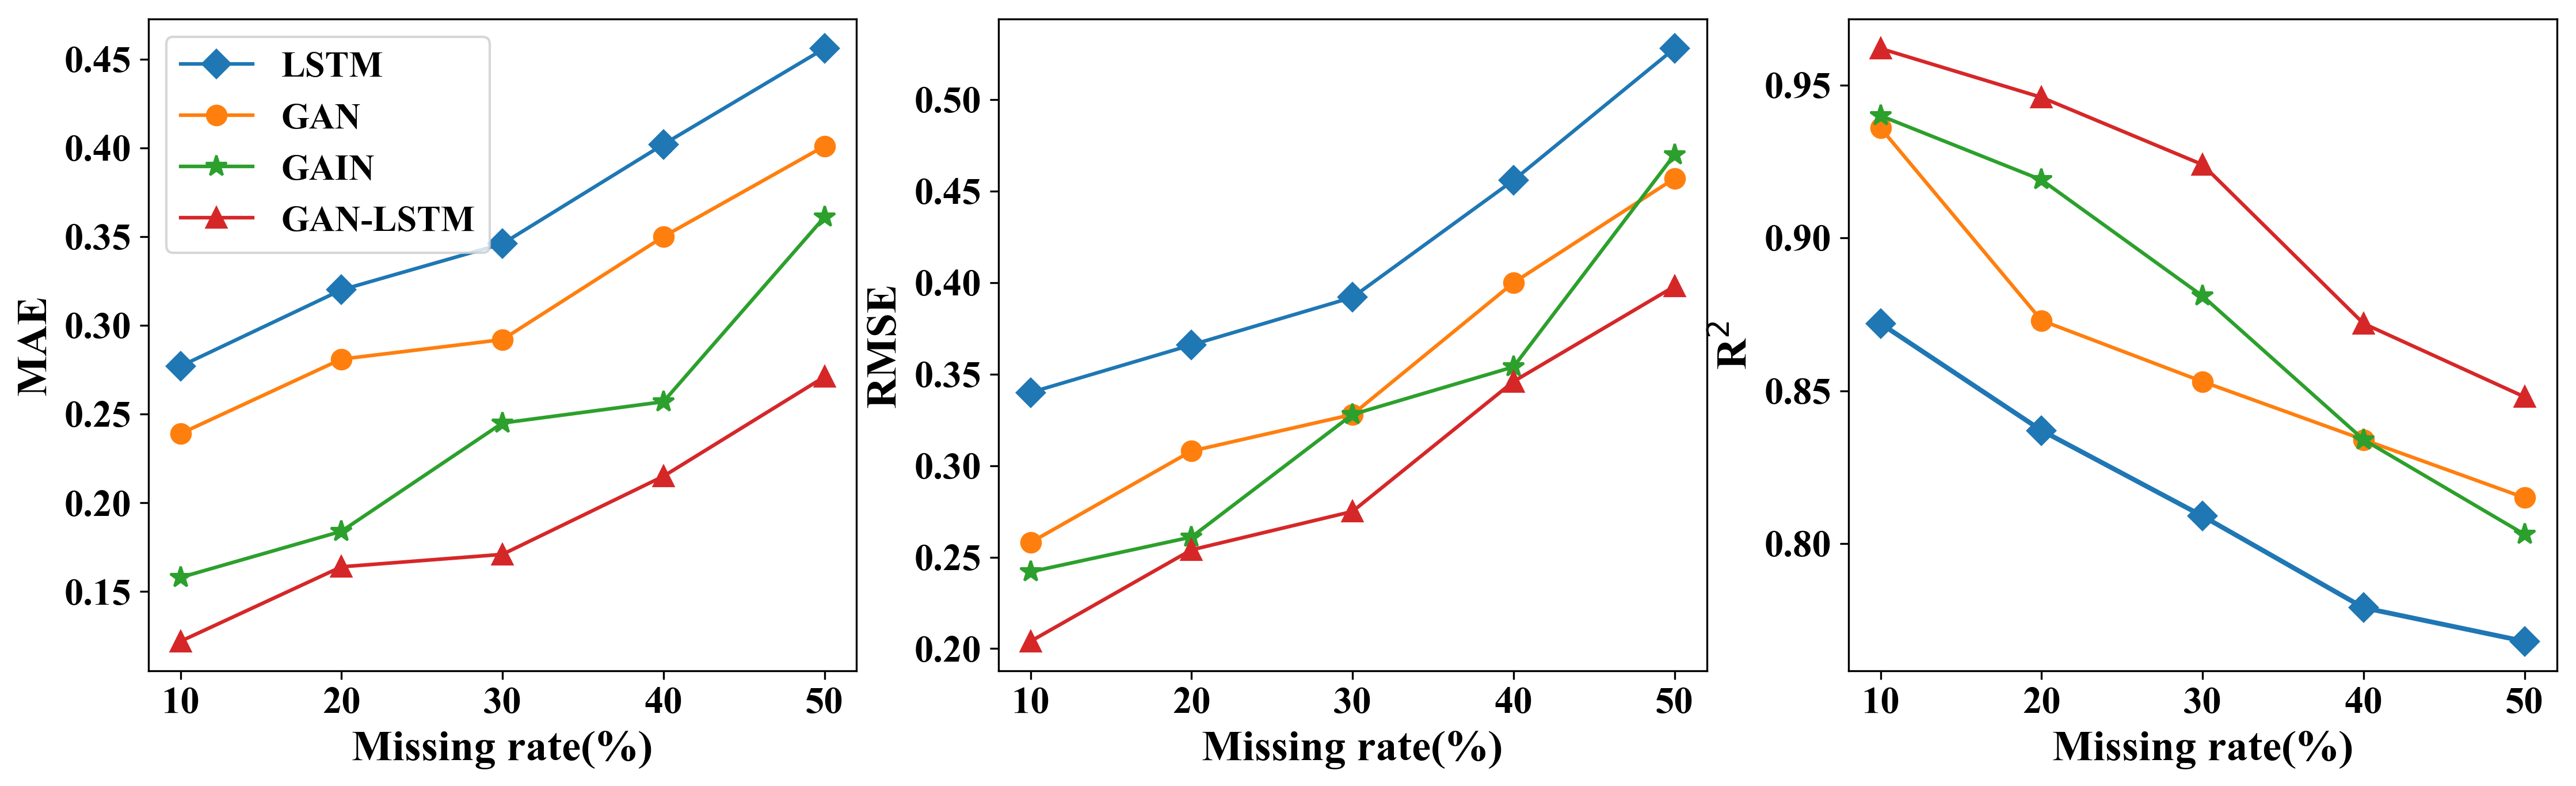

In [2]:
mae = pd.read_csv('./OUTPUT/error_output/MAE.csv')
rmse = pd.read_csv('./OUTPUT/error_output/RMSE.csv')
r2 = pd.read_csv('./OUTPUT/error_output/R2.csv')

from matplotlib.ticker import MultipleLocator,FormatStrFormatter
xmajorLocator = MultipleLocator(1)
ymajorLocator = MultipleLocator(0.05)

font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':16
}
font2 = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':18
}
matplotlib.rc("font", **font)
fig = plt.figure(figsize = (18,5), dpi = 300)

x = [i for i in range(0, 5)]
ax1 = plt.subplot(1,3,1)
ax1.plot(x,mae.loc[:,'LSTM_R'].values,label='LSTM',linestyle='-',marker='D',markersize=8)
ax1.plot(x,mae.loc[:,'GAN_R'].values,label='GAN',linestyle='-',marker='o',markersize=8)
ax1.plot(x,mae.loc[:,'GAIN_R'].values,label='GAIN',linestyle='-',marker='*',markersize=9)
ax1.plot(x,mae.loc[:,'GAN-LSTM_R'].values,label='GAN-LSTM',linestyle='-',marker='^',markersize=8)
ax1.set_xlabel('Missing rate(%)',font2)
ax1.set_ylabel('MAE',font2)
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.legend(fontsize=15)
# ax1.set_xlim(0,5)
ax1.set_xticklabels(['0','10','20','30','40','50'])

ax2 = plt.subplot(1,3,2)
ax2.plot(x,rmse.loc[:,'LSTM_R'].values,label='LSTM',linestyle='-',marker='D',markersize=8)
ax2.plot(x,rmse.loc[:,'GAN_R'].values,label='GAN',linestyle='-',marker='o',markersize=8)
ax2.plot(x,rmse.loc[:,'GAIN_R'].values,label='GAIN',linestyle='-',marker='*',markersize=9)
ax2.plot(x,rmse.loc[:,'GAN-LSTM_R'].values,label='GAN-LSTM',linestyle='-',marker='^',markersize=8)
ax2.set_xlabel('Missing rate(%)',font2)
ax2.set_ylabel('RMSE',font2)
ax2.xaxis.set_major_locator(xmajorLocator)
ax2.yaxis.set_major_locator(ymajorLocator)
# ax1.set_xlim(0,5)
ax2.set_xticklabels(['0','10','20','30','40','50'])

ax3 = plt.subplot(1,3,3)
ax3.plot(x,r2.loc[:,'LSTM_R'].values,label='LSTM',linestyle='-',linewidth=2,marker='D',markersize=8)
ax3.plot(x,r2.loc[:,'GAN_R'].values,label='GAN',linestyle='-',marker='o',markersize=8)
ax3.plot(x,r2.loc[:,'GAIN_R'].values,label='GAIN',linestyle='-',marker='*',markersize=9)
ax3.plot(x,r2.loc[:,'GAN-LSTM_R'].values,label='GAN-LSTM',linestyle='-',marker='^',markersize=8)
ax3.set_xticklabels(['0','10%','20%','30%','40%','50%'])
ax3.set_xlabel('Missing rate(%)',font2)
ax3.set_ylabel(r'R$^2$',font2)
ax3.xaxis.set_major_locator(xmajorLocator)
ax3.set_xticklabels(['0','10','20','30','40','50'])

# plt.savefig('./OUTPUT/pic_output/ERROR/ERROR_R.tif')

# 缺失补全应用

## 数据分块，调整为适配模型的输入格式

由于本次实验中所用的曲线长度设定为了150个采样点，故将应用井切分成4份不同的输入

In [16]:
#缺失井为L123
ultra = pd.read_csv('./INPUT/curve_app/L123_miss.csv')

curves = ['AC_point_3','GR','SP','RT','SH','POR','PERM','SW','DEPTH',]
X_1 = ultra.loc[:149,curves].fillna(0.5).values
Y_1 = ultra.loc[:149,'AC'].values
M_1 = ultra.loc[:149,'R_3_MASK'].values

X_2 = ultra.loc[150:299,curves].fillna(0.5).values
Y_2 = ultra.loc[150:299,'AC'].values
M_2 = ultra.loc[150:299,'R_3_MASK'].values

X_3 = ultra.loc[300:449,curves].fillna(0.5).values
Y_3 = ultra.loc[300:449,'AC'].values
M_3 = ultra.loc[300:449,'R_3_MASK'].values

X_4 = ultra.loc[450:599,curves].fillna(0.5).values
Y_4 = ultra.loc[450:599,'AC'].values
M_4 = ultra.loc[450:599,'R_3_MASK'].values

## 集中预测结果(示例)

In [17]:
params = dict()
# params['processed_test_dir'] = './INPUT/processed_test/' 
params['miss_type'] = 'Random'
params['nan_rate'] = 0.3
params['len_input'] = 150
params['model_type'] = params['miss_type']+str(params['nan_rate'])
LSTM_Imputer = tf.keras.models.load_model('./OUTPUT/saved_models/Demo/'+'LSTM'+'_'+
                                          params['model_type']+'.h5')
GAN_Imputer = tf.keras.models.load_model('./OUTPUT/saved_models/Demo/'+'GAN'+'_'+
                                          params['model_type']+'.h5')
GAIN_Imputer = tf.keras.models.load_model('./OUTPUT/saved_models/Demo/'+'GAIN'+'_'+
                                          params['model_type']+'.h5')
GAN_LSTM_Imputer = tf.keras.models.load_model('./OUTPUT/saved_models/Demo/'+'GAN_LSTM'+'_'+
                                          params['model_type']+'.h5')

#第一段
Y_1 = Y_1.reshape(1,150)
M_1 = M_1.reshape(1,150)
X_1 = X_1[np.newaxis,:,:]
Y_1_after, Complete1_1,_ = get_Y_and_P(LSTM_Imputer,X_1,Y_1,M_1,True)
Y_1_after,Complete1_2,_ = get_Y_and_P(GAN_Imputer,X_1,Y_1,M_1)
Y_1_after,Complete1_3,_ = get_Y_and_P(GAIN_Imputer,X_1,Y_1,M_1)
Y_1_after,Complete1_4,_ = get_Y_and_P(GAN_LSTM_Imputer,X_1,Y_1,M_1)

#第二段
Y_2 = Y_2.reshape(1,150)
M_2 = M_2.reshape(1,150)
X_2 = X_2[np.newaxis,:,:]
Y_2_after, Complete2_1,_ = get_Y_and_P(LSTM_Imputer,X_2,Y_2,M_2,True)
Y_2_after,Complete2_2,_ = get_Y_and_P(GAN_Imputer,X_2,Y_2,M_2)
Y_2_after,Complete2_3,_ = get_Y_and_P(GAIN_Imputer,X_2,Y_2,M_2)
Y_2_after,Complete2_4,_ = get_Y_and_P(GAN_LSTM_Imputer,X_2,Y_2,M_2)

#第三段
Y_3 = Y_3.reshape(1,150)
M_3 = M_3.reshape(1,150)
X_3 = X_3[np.newaxis,:,:]
Y_3_after, Complete3_1,_ = get_Y_and_P(LSTM_Imputer,X_3,Y_3,M_3,True)
Y_3_after,Complete3_2,_ = get_Y_and_P(GAN_Imputer,X_3,Y_3,M_3)
Y_3_after,Complete3_3,_ = get_Y_and_P(GAIN_Imputer,X_3,Y_3,M_3)
Y_3_after,Complete3_4,_ = get_Y_and_P(GAN_LSTM_Imputer,X_3,Y_3,M_3)

#第四段
Y_4 = Y_4.reshape(1,150)
M_4 = M_4.reshape(1,150)
X_4 = X_4[np.newaxis,:,:]
Y_4_after, Complete4_1,_ = get_Y_and_P(LSTM_Imputer,X_4,Y_4,M_4,True)
Y_4_after,Complete4_2,_ = get_Y_and_P(GAN_Imputer,X_4,Y_4,M_4)
Y_4_after,Complete4_3,_ = get_Y_and_P(GAIN_Imputer,X_4,Y_4,M_4)
Y_4_after,Complete4_4,_ = get_Y_and_P(GAN_LSTM_Imputer,X_4,Y_4,M_4)

period1 = pd.DataFrame([Complete1_1,Complete1_2,Complete1_3,Complete1_4]).T
period2 = pd.DataFrame([Complete2_1,Complete2_2,Complete2_3,Complete2_4]).T
period3 = pd.DataFrame([Complete3_1,Complete3_2,Complete3_3,Complete3_4]).T
period4 = pd.DataFrame([Complete4_1,Complete4_2,Complete4_3,Complete4_4]).T
_4_predict = pd.concat([period1,period2,period3,period4],axis=0).reset_index(drop=True)
_4_predict.columns=['LSTM','GAN','GAIN','GAN-LSTM']

X = ultra[curves]
X['AC'] = ultra.AC
X['MASK'] = ultra.R_3_MASK

M=ultra.R_3_MASK
M_df = pd.DataFrame(M)
M_df_notnull = M_df[M_df!=0].dropna()
Index = M_df_notnull.index.to_list()
X['index'] = Index+(600-len(Index))*[np.nan]
output_df = pd.concat([X,_4_predict],axis=1)


W1129 23:45:05.045536 14928 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1129 23:45:05.465701 14928 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1129 23:45:05.596371 14928 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W1129 23:45:05.874065 14928 hdf5_format.py:177] No training configuration found in save file: the model was *not* compiled. Compile it manually.
d:\python\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is tryin

In [18]:
#再次定义一下分界点，用以标红缺失部分
def get_cut(Index,params):
    new_random_1 = []
    for i in range(0,len(Index)-1):
        #只要有一边不等于1，我们都把他列出来
        if (Index[i]-Index[i-1]!=1)or(Index[i+1]-Index[i]!=1):
            this_one = Index[i]
            new_random_1.append(this_one)
            
    new_random_2 = []   
    Index_reverse = Index[::-1]
    for i in range(0,len(Index_reverse)-1):
        #只要有一边不等于1，我们都把他列出来
        if (Index_reverse[i]-Index_reverse[i-1]!=(-1))or(Index_reverse[i+1]-Index_reverse[i]!=(-1)):
            this_one = Index_reverse[i]
            new_random_2.append(this_one)
    CUT = np.unique(new_random_1+new_random_2).tolist()       
         
    if 0 in CUT:
        mode = 'reverse'
    else:
        mode = 'normal'
    CUT.extend([0,599])
    CUT.sort()
    return CUT,mode

Index = list(output_df['index'].dropna())
Index = [int(i) for i in Index]

CUT,_ = get_cut(Index,params)


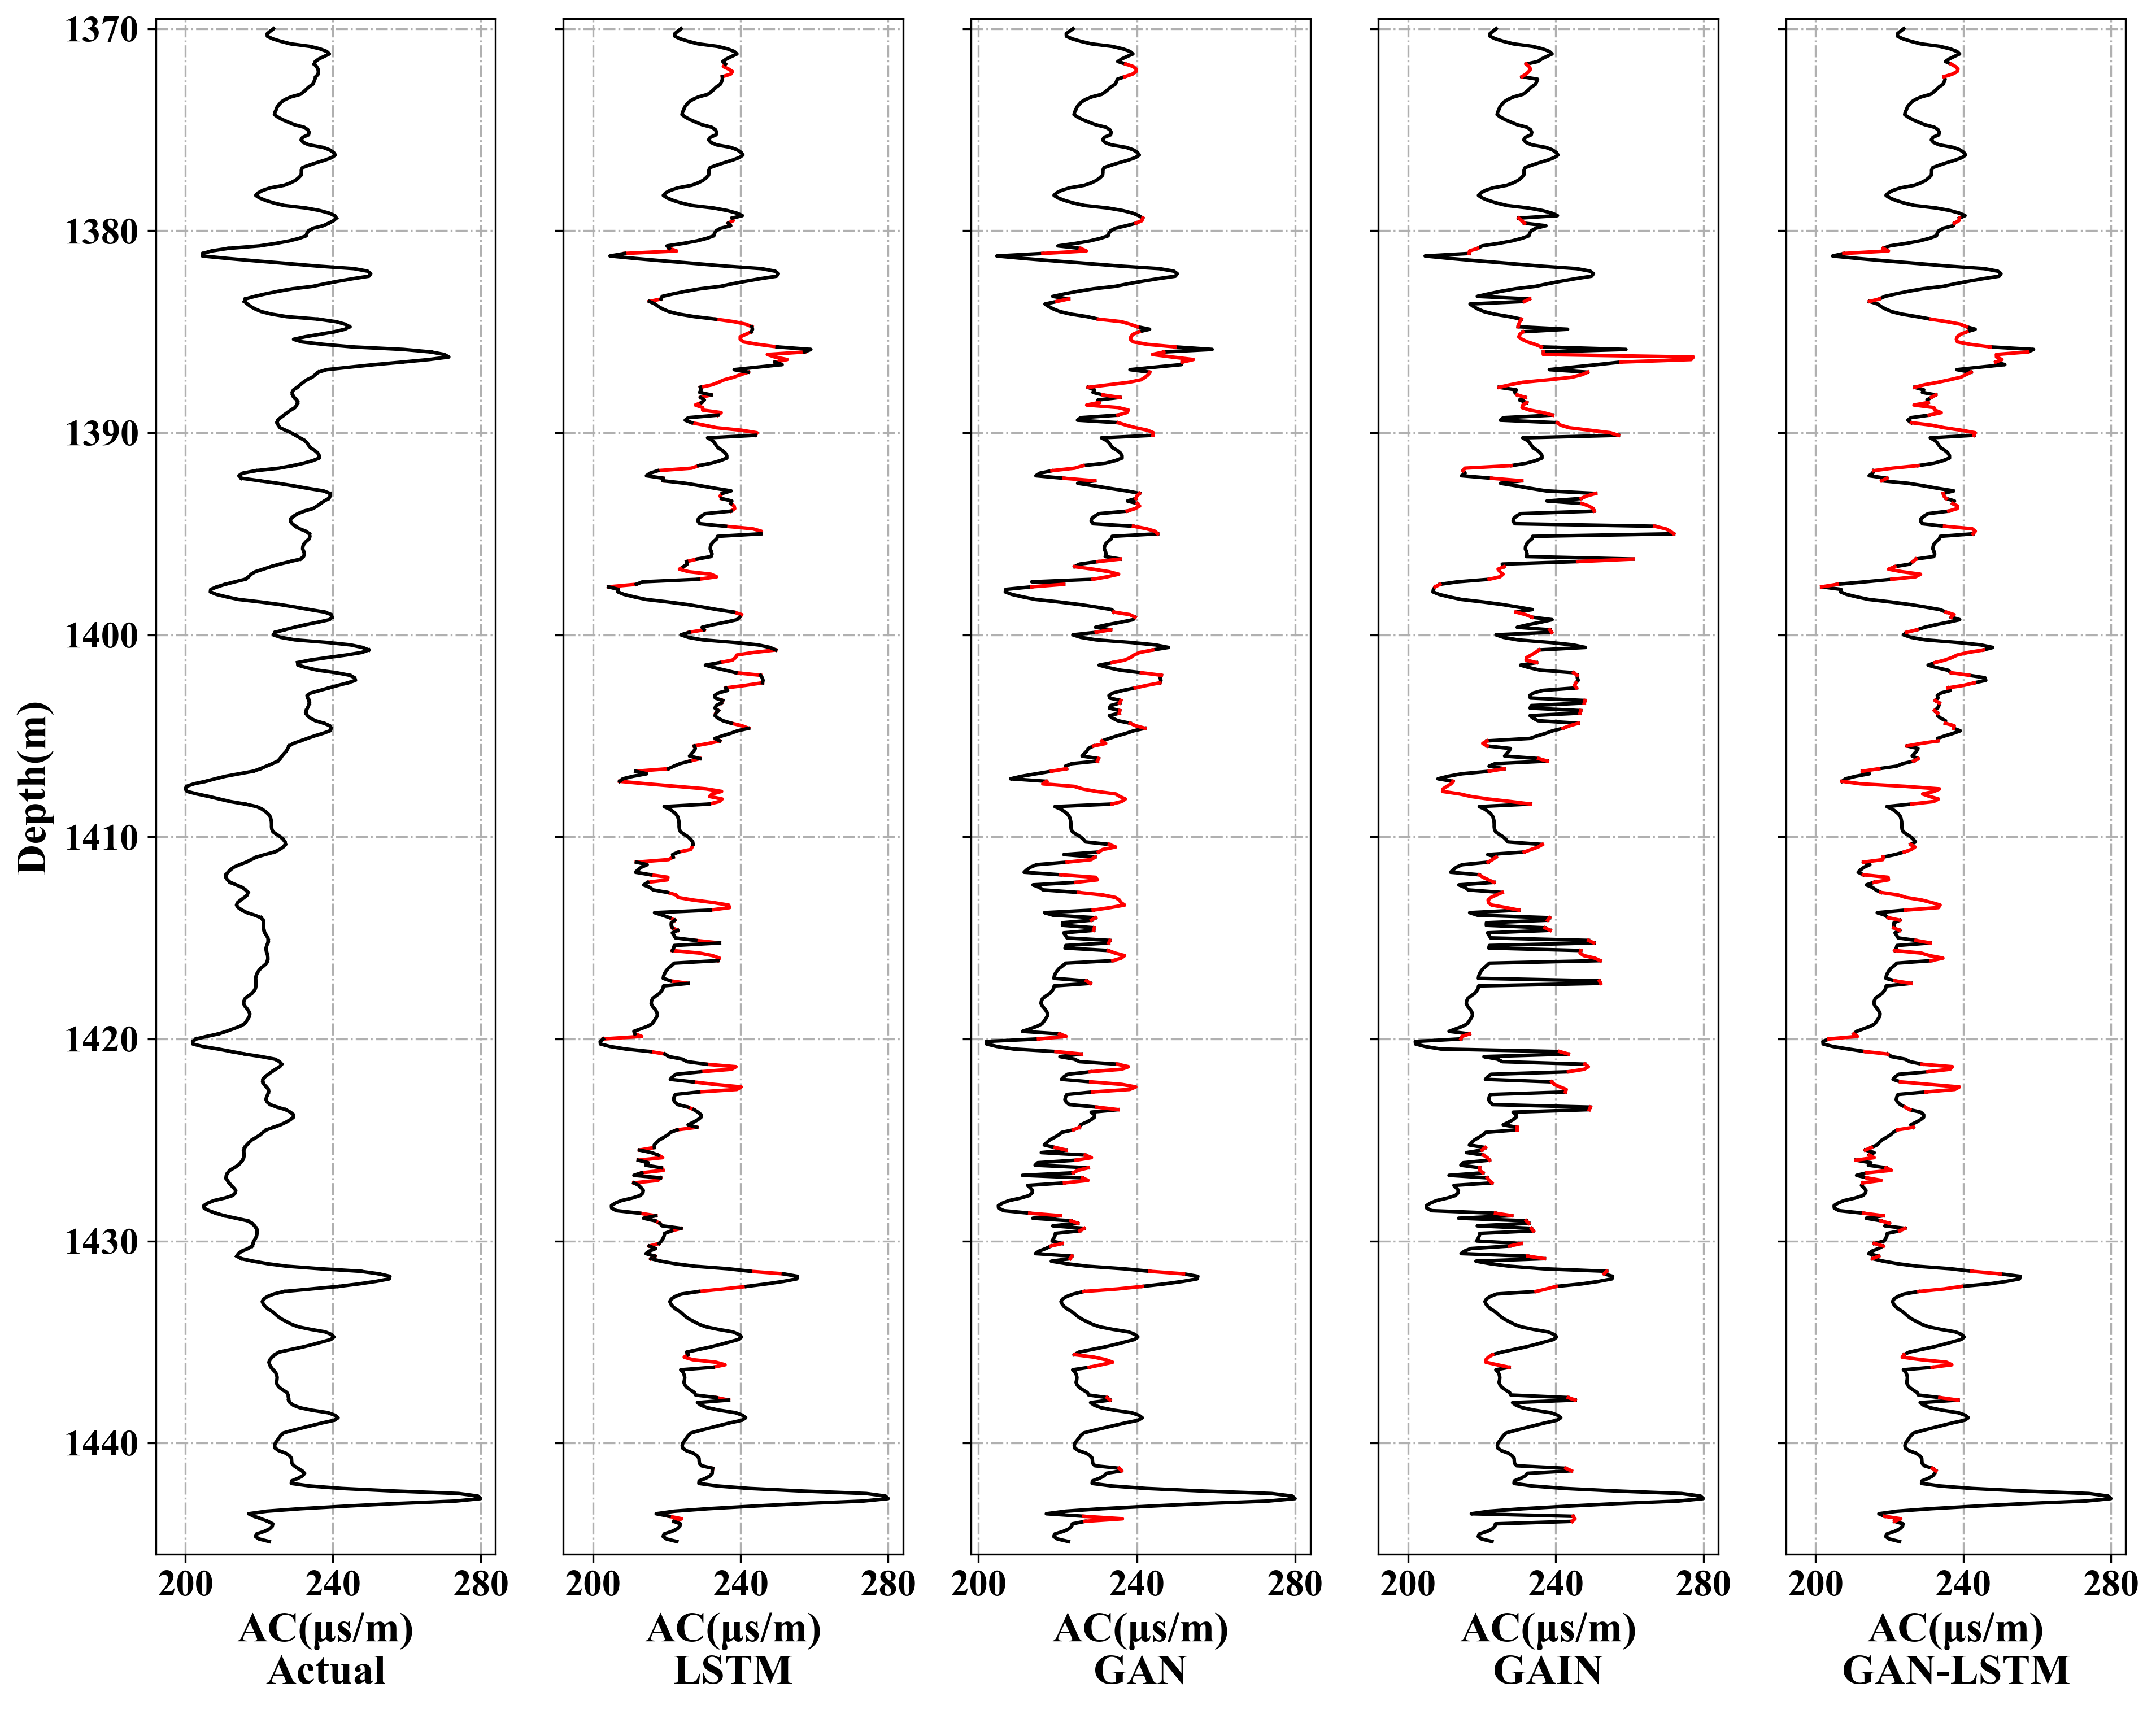

In [19]:
font = {
'family':'Times New Roman',
#'weight':'bold',
'size':16
}
font2 = {
'family':'Times New Roman',
#'weight':'bold',
'size':18
}

matplotlib.rc("font", **font)

Y = output_df.AC.values

# output_modify = pd.read_csv('./OUTPUT/30%/R.csv')
Complete1 = output_df['LSTM']
Complete2 = output_df['GAN']
Complete3 = output_df['GAIN']
Complete4 = output_df['GAN-LSTM']

CUT,mode = get_cut(Index,params)
# CUT = [0,225,470,599]
CUT_value,CUT_nan = get_cut_value_and_nan(CUT,mode)

fig = plt.figure(figsize = (15,12), dpi = 300)
#这个画原图    
ax1 = plt.subplot(1,5,1)
ax1.set_ylim(-0.5+1370,75.5+1370)
ax1.invert_yaxis()

for i in range(len(CUT_value)):
    ax1.plot(Y[CUT_value[i]], np.array(CUT_value[i])*0.125+1370, 'k')
for i in range(len(CUT_nan)):
    ax1.plot(Y[CUT_nan[i]],np.array(CUT_nan[i])*0.125+1370, 'k')

ax1.set_xlim(-0.1,1.05)
ax1.set_xticklabels([0,200,240,280])
ax1.set_xlabel("AC(μs/m)\nActual",font2)
ax1.set_ylabel('Depth(m)',font2)
ax1.grid(linestyle='-.')
    
#这个画补全图    
ax2 = plt.subplot(1,5,2)
ax2.set_ylim(-0.5,75.5)

ax2.invert_yaxis()

for i in range(len(CUT_nan)):
    ax2.plot(Complete1[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r') 
for i in range(len(CUT_value)):
    ax2.plot(Complete1[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
ax2.set_xlim(-0.1,1.05)
ax2.set_xticklabels([0,200,240,280])
ax2.set_xlabel("AC(μs/m)\nLSTM",font2)
# ax2.set_ylabel('Depth(m)')
ax2.grid(linestyle='-.')

yticks = ax2.yaxis.get_major_ticks()
for j in range(len(yticks)):
    yticks[j].label1.set_visible(False)

ax3 = plt.subplot(1,5,3)
ax3.set_ylim(-0.5,75.5)
ax3.invert_yaxis()
for i in range(len(CUT_value)):
    ax3.plot(Complete2[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
for i in range(len(CUT_nan)):
    ax3.plot(Complete2[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r')  
# ax3.set_xlim(-0.5,75.5)
ax3.set_xticklabels([0,200,240,280])
ax3.set_xlabel("AC(μs/m)\nGAN",font2)
# ax3.set_ylabel('Depth(m)')
ax3.grid(linestyle='-.')
yticks = ax3.yaxis.get_major_ticks()
for j in range(len(yticks)):
    yticks[j].label1.set_visible(False)

ax4 = plt.subplot(1,5,4)
ax4.set_ylim(-0.5,75.5)
ax4.invert_yaxis()
for i in range(len(CUT_value)):
    ax4.plot(Complete3[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
for i in range(len(CUT_nan)):
    ax4.plot(Complete3[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r')  
ax4.set_xlim(-0.1,1.05)
ax4.set_xticklabels([0,200,240,280])

ax4.set_xlabel("AC(μs/m)\nGAIN",font2)
# ax4.set_ylabel('Depth(m)')
ax4.grid(linestyle='-.')
yticks = ax4.yaxis.get_major_ticks()
for j in range(len(yticks)):
    yticks[j].label1.set_visible(False)

ax5 = plt.subplot(1,5,5)
ax5.set_ylim(-0.5,75.5)
ax5.invert_yaxis()
for i in range(len(CUT_value)):
    ax5.plot(Complete4[CUT_value[i]], np.array(CUT_value[i])*0.125, 'k')
for i in range(len(CUT_nan)):
    ax5.plot(Complete4[CUT_nan[i]],np.array(CUT_nan[i])*0.125, 'r')  
ax5.set_xlim(-0.1,1.05)
ax5.set_xticklabels([0,200,240,280])

ax5.set_xlabel("AC(μs/m)\nGAN-LSTM",font2)
# ax5.set_ylabel('Depth(m)')
ax5.grid(linestyle='-.')
yticks = ax5.yaxis.get_major_ticks()
for j in range(len(yticks)):
    yticks[j].label1.set_visible(False)
# plt.savefig('./OUTPUT/30%R.tif')